# CoE_Test 3

## import

### function

In [1]:
import numpy as np
import geatpy as ga
from decimal import Decimal

def rosen(alpha=1e2,**X):
    x = [X[key]/10 for key in X.keys()]
    """Rosenbrock test objective function"""
    x = [x] if np.isscalar(x[0]) else x  # scalar into list
    x = np.asarray(x)
    f = [sum(alpha * (x[:-1]**2 - x[1:])**2 + (1. - x[:-1])**2) for x in x]
    return f if len(f) > 1 else f[0]  # 1-element-list into scalar

def schwefelmult(pen_fac=1e4, **X):
    x = np.array([X[key]/10 for key in X.keys()])
    """multimodal Schwefel function with domain -500..500"""
    y = [x] if np.isscalar(x[0]) else x
    N = len(y[0])
    f = np.array([418.9829 * N - 1.27275661e-5 * N - sum(x * np.sin(np.abs(x)**0.5))
            + pen_fac * sum((abs(x) > 500) * (abs(x) - 500)**2) for x in y])
    return f if len(f) > 1 else f[0]

def levy(**X):
    """a rather benign multimodal function.

    xopt == ones, fopt == 0.0
    """
    x = np.array([X[key]/10 for key in X.keys()])
    w = 1 + (np.asarray(x) - 1) / 4
    del x
    f = np.sin(np.pi * w[0])**2
    f += (w[-1] - 1)**2 * (1 + np.sin(2 * np.pi * w[-1])**2)
    w = w[1:-1]
    return f + sum((w - 1)**2 * (1 + 10 * np.sin(np.pi * w + 1)**2))

def elliconstraint(cfac=1e8, tough=True, cond=1e6, **X):
    x = np.array([X[key]/10 for key in X.keys()])
    """ellipsoid test objective function with "constraints" """
    N = len(x)
    f = sum(cond**(np.arange(N)[-1::-1] / (N - 1)) * x**2)
    cvals = (x[0] + 1,
             x[0] + 1 + 100 * x[1],
             x[0] + 1 - 100 * x[1])
    if tough:
        f += cfac * sum(max(0, c) for c in cvals)
    else:
        f += cfac * sum(max(0, c + 1e-3)**2 for c in cvals)
    return f

def spherew(**X):
    x = np.array([X[key]/10 for key in X.keys()])
    """Sphere (squared norm) with sum x_i = 1 test objective function"""
    # return np.random.rand(1)[0]**0 * sum(x**2) + 1 * np.random.rand(1)[0]
    # s = sum(abs(x))
    # return sum((x/s+0)**2) - 1/len(x)
    # return sum((x/s)**2) - 1/len(x)
    return -0.01 * x[0] + abs(x[0])**-2 * sum(x[1:]**2)

# rosen(**dict(zip(keys,P)))

### ga

In [2]:
dim = 8
keys = ['x', 'y', 'z', 'x1', 'y1', 'z1', 'x2', 'y2']
ranges = np.vstack([[0, 10], [0, 10], [0, 10], [0, 10], [0, 10], [0, 9], [0, 10], [0, 9]]).T
borders = np.vstack([[0, 0]] * dim).T
precisions = np.array([4, 4, 4, 4, 4, 0, 4, 0])
codes = np.array([None, None, None, None, None, 1, None, 1])
scales = np.array([0] * dim)
FieldDR = ga.crtfld(ranges, borders, list(precisions)) 
FieldDR

array([[1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04,
        1.0000e+00, 1.0000e-04, 1.0000e+00],
       [9.9999e+00, 9.9999e+00, 9.9999e+00, 9.9999e+00, 9.9999e+00,
        8.0000e+00, 9.9999e+00, 8.0000e+00]])

In [3]:
ranges = np.vstack([[0, 10], [0, 10], [0, 10], [0, 10], [0, 10], [0, 9], [0, 10], [0, 9]]).T
borders = np.vstack([[0, 0]] * dim).T
precisions = np.array([4, 4, 4, 4, 4, 0, 0, 0])
codes = np.array([1, 1, 1, 1, 1, 1, 1, 1])
scales = np.array([0] * dim)
FieldD = ga.crtfld(ranges, borders, list(precisions), list(codes), list(scales))
FieldD

array([[17, 17, 17, 17, 17, 4, 4, 4],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [10, 10, 10, 10, 10, 9, 10, 9],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=object)

## Create base function

### rep

In [4]:
# MatIn = [1 2 3]
# REPN = [1 2]: MatOut = [1 2 3 1 2 3]
# REPN = [2 1]: MatOut = [1 2 3;
#                        1 2 3]
# REPN = [3 2]: MatOut = [1 2 3 1 2 3;
#                        1 2 3 1 2 3;
#                        1 2 3 1 2 3]

def rep(MatIn,REPN):
    N  = MatIn.shape
    # Calculate
    Ind_D = np.remainder(np.arange(0,REPN[0]*N[0]),N[0])
    Ind_L = np.remainder(np.arange(0,REPN[1]*N[1]),N[1])

    # Create output matrix
    MatOut = np.zeros((REPN[0]*N[0], REPN[1]*N[1]), dtype=MatIn.dtype)
    for i, ind_d in enumerate(Ind_D):
        for j, ind_l in enumerate(Ind_L):
            MatOut[i,j] = MatIn[ind_d,ind_l]
    return MatOut

In [5]:
MatIn = np.array([[1,2,3]])
REPN = [3,2]
MatOut = rep(MatIn,REPN)
MatOut

array([[1, 2, 3, 1, 2, 3],
       [1, 2, 3, 1, 2, 3],
       [1, 2, 3, 1, 2, 3]])

### crtfld

In [6]:
def get_decimals_bit(value):
    value_p = str(value).split(".")
    try:
        if float(value_p[1]) == 0:
            return int(0)
        else: 
            return len(value_p[1])
    except IndexError:
        return int(0)
    
get_decimals_bit(123.0001)

4

In [7]:
def round_lb(value, precision, border):
    value_p = get_decimals_bit(value)
    value_str = str(value+0.1**precision*abs(bool(border)-1)) if precision >= value_p else str(value)
    precision_str = '0.'+''.join(['0']*precision)
    rounding = "ROUND_CEILING" if abs(bool(border)-1) else "ROUND_FLOOR"
    value_deal = Decimal(value_str).quantize(Decimal(precision_str), rounding = rounding)  
    return int(value_deal) if precision == 0 else float(value_deal)
round_lb(-2.1144, 5, 0)

-2.11438

In [8]:
def round_ub(value, precision, border):
    value_p = get_decimals_bit(value)
    value_str = str(value-0.1**precision*abs(bool(border)-1)) if precision >= value_p else str(value)
    precision_str = '0.'+''.join(['0']*precision)
    rounding = "ROUND_FLOOR" if abs(bool(border)-1) else "ROUND_CEILING"
    value_deal = Decimal(value_str).quantize(Decimal(precision_str), rounding = rounding)  
    return int(value_deal) if precision == 0 else float(value_deal)
round_ub(2.11441341515, 2, 1)

2.12

In [9]:
def crtfld(ranges, borders=None, precisions=None, codes=None, scales=None):
    dim = ranges.shape[1]
    lb = [round_lb(ranges[0][x],precisions[x], borders[0][x]) for x in range(dim)]
    ub = [round_ub(ranges[1][x],precisions[x], borders[1][x]) for x in range(dim)]
    if codes == None:
        FieldDR = np.array([lb, ub])
        return FieldDR
    else:
        scales = [0] * dim if scales is None else scales
        lbin = [1 if precisions[x] == 0 and borders[0][x]==0 else borders[0][x] for x in range(dim)]
        ubin = [1 if precisions[x] == 0 and borders[1][x]==0 else borders[1][x] for x in range(dim)]
        len_ = [int((x-y)*10**p).bit_length() for p,x,y in zip(precisions,ub,lb)]
        FieldD = np.array([len_, lb, ub, codes, scales, lbin, ubin], dtype=object)
        return FieldD

In [10]:
dim = 8
keys = ['x', 'y', 'z', 'x1', 'y1', 'z1', 'x2', 'y2']
ranges = np.vstack([[0, 10], [0, 10], [0, 10], [0, 10], [0, 10], [1, 8], [-3, 5], [0, 9]]).T
borders = np.vstack([[1, 0], [1, 0],  [1, 0],  [1, 0],  [1, 0],  [0, 0], [1, 0],  [0, 0]]).T
precisions = np.array([4, 4, 4, 4, 0, 0, 0, 0])
codes = np.array([1, 1, 1, 1, 1, 1, 1, 1])
scales = np.array([0] * dim)
FieldDR = ga.crtfld(ranges, borders, list(precisions))
ga.crtfld(ranges, borders=borders, precisions=list(precisions), codes=list(codes), scales=list(scales))

array([[17, 17, 17, 17, 4, 3, 4, 4],
       [0, 0, 0, 0, 0, 1, -3, 0],
       [10, 10, 10, 10, 10, 8, 5, 9],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=object)

In [11]:
crtfld(ranges, borders=borders, precisions=list(precisions), codes=list(codes), scales=list(scales))

array([[17, 17, 17, 17, 4, 3, 3, 3],
       [0.0, 0.0, 0.0, 0.0, 0, 2, -3, 1],
       [9.9999, 9.9999, 9.9999, 9.9999, 9, 7, 4, 8],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1]], dtype=object)

In [12]:
FieldDR

array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  2.    , -3.    ,
         1.    ],
       [ 9.9999,  9.9999,  9.9999,  9.9999,  9.    ,  7.    ,  4.    ,
         8.    ]])

In [13]:
crtfld(ranges, borders, list(precisions))

array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  2.    , -3.    ,
         1.    ],
       [ 9.9999,  9.9999,  9.9999,  9.9999,  9.    ,  7.    ,  4.    ,
         8.    ]])

In [14]:
x1 = [-3, 5] # 自变量1的范围
x2 = [2, 10] # 自变量2的范围
b1 = [1, 0] # 自变量1的边界
b2 = [1, 1] # 自变量2的边界
codes = [0, 1] # 变量编码方式，分别采用二进制和格雷编码
precisions = [0, 0] # 各变量的精度，0表示精确到个位
scales = [1, 0] # 采用算术刻度
ranges = np.vstack([x1, x2]).T # 生成自变量的范围矩阵
borders = np.vstack([b1, b2]).T # 生成自变量的边界矩阵
# 调用crtfld函数生成区域描述器
ga.crtfld(ranges, borders, precisions, codes, scales)

array([[3, 4],
       [-3, 2],
       [4, 10],
       [0, 1],
       [1, 0],
       [1, 1],
       [1, 1]], dtype=object)

In [15]:
crtfld(ranges, borders, precisions, codes, scales)

array([[3, 4],
       [-3, 2],
       [4, 10],
       [0, 1],
       [1, 0],
       [1, 1],
       [1, 1]], dtype=object)

In [16]:
codes = [0, 1, 0, 0, 0, 0, 0, 0] # 变量编码方式，分别采用二进制和格雷编码
precisions = [0, 1, 0, 0, 0, 0, 0, 0] # 各变量的精度，0表示精确到个位
scales = [1, 0, 1, 1, 1, 1, 1, 1] # 采用算术刻度
ranges = np.vstack([[-3, 5], [2, 10], [-3, 5], [2, 10], [-3, 5], [2, 10], [-3, 5], [2, 10]]).T # 生成自变量的范围矩阵
borders = np.vstack([[1, 0], [1, 1],  [1, 0],  [1, 1],  [1, 0],  [1, 1],  [1, 0],  [1, 1]]).T # 生成自变量的边界矩阵
# 调用crtfld函数生成区域描述器
ga.crtfld(ranges, borders, precisions, codes, scales)

array([[4, 7, 4, 4, 4, 4, 4, 4],
       [-3, 2, -3, 2, -3, 2, -3, 2],
       [5, 10, 5, 10, 5, 10, 5, 10],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 0, 1, 0, 1, 0, 1]], dtype=object)

In [17]:
dim = 8
ranges = np.vstack([[0, 10.1], [0, 10], [0, 10], [0, 10], [0, 10], [1, 8], [-3, 5], [2, 10]]).T
borders = np.vstack([[1, 1], [1, 0],  [1, 0],  [1, 0],  [1, 0],  [0, 0], [1, 0],  [0, 0]]).T
precisions = [4, 0, 0, 0, 0, 0, 0, 0]
codes = [1, 1, 1, 1, 1, 1, 1, 1]
scales = [0] * dim
ga.crtfld(ranges, borders, precisions, codes, scales)

array([[17, 4, 4, 4, 4, 3, 4, 4],
       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -3.0, 2.0],
       [10.1, 10.0, 10.0, 10.0, 10.0, 8.0, 5.0, 10.0],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0]], dtype=object)

In [18]:
# 问题：原函数精度要全部为0才进行重整
dim = ranges.shape[1]
lb = [ranges[0][x]+1 if (np.array(precisions)== 0).all() and borders[0][x]==0 else ranges[0][x] for x in range(dim)]
ub = [ranges[1][x]-1 if (np.array(precisions)== 0).all() and borders[1][x]==0 else ranges[1][x] for x in range(dim)]
scales = [0] * dim if scales is None else scales
lbin = [1 if (np.array(precisions)== 0).all() and borders[0][x]==0 else borders[0][x] for x in range(dim)]
ubin = [1 if (np.array(precisions)== 0).all() and borders[1][x]==0 else borders[1][x] for x in range(dim)]
len_ = [(int(x-y)*10**p).bit_length() for p,x,y in zip(precisions,ub,lb)]
FieldD = np.array([len_, lb, ub, codes, scales, lbin, ubin], dtype=object)
FieldD

array([[17, 4, 4, 4, 4, 3, 4, 4],
       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -3.0, 2.0],
       [10.1, 10.0, 10.0, 10.0, 10.0, 8.0, 5.0, 10.0],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0]], dtype=object)

In [19]:
x1 = [-2.5, 2] # 自变量1的范围
x2 = [3, 5] # 自变量2的范围
x3 = [-4.8, 3.6] # 自变量3的范围
b1 = [0, 0] # 自变量1的边界
b2 = [0, 0] # 自变量2的边界
b3 = [1, 0] # 自变量3的边界
precisions =[3, 0, 4] # 各变量的精度，3表示精确到小数点后3位
ranges = np.vstack([x1, x2, x3]).T # 生成自变量的范围矩阵
borders = np.vstack([b1, b2, b3]).T # 生成自变量的边界矩阵
# 调用crtfld函数生成区域描述器
ga.crtfld(ranges, borders, precisions)

array([[-2.499 ,  4.    , -4.8   ],
       [ 1.999 ,  4.    ,  3.5999]])

In [20]:
# 问题：当精度小于给定变量精度时会产生bug，如果不包含边界，会使精度位减少
dim = ranges.shape[1]
lb = [ranges[0][x]+0.1**precisions[x] if borders[0][x]==0 else ranges[0][x] for x in range(dim)]
ub = [ranges[1][x]-0.1**precisions[x] if borders[1][x]==0 else ranges[1][x] for x in range(dim)]
# scales = [0] * dim if scales is None else scales
# lbin = [borders[0][x] if precisions[x] > 0 or borders[0][x]==1 else 1 for x in range(dim)]
# ubin = [borders[1][x] if precisions[x] > 0 or borders[1][x]==1 else 1 for x in range(dim)]
# len_ = [int(x-y).bit_length() for x,y in zip(ub,lb)]
FieldDR = np.array([lb, ub])
FieldDR

array([[-2.499 ,  4.    , -4.8   ],
       [ 1.999 ,  4.    ,  3.5999]])

In [21]:
# 整体进行一个改进
dim = ranges.shape[1]
lb = [round_lb(ranges[0][x],precisions[x], borders[0][x]) for x in range(dim)]
ub = [round_ub(ranges[1][x],precisions[x], borders[1][x]) for x in range(dim)]
scales = [0] * dim if scales is None else scales
lbin = [1 if precisions[x] == 0 and borders[0][x]==0 else borders[0][x] for x in range(dim)]
ubin = [1 if precisions[x] == 0 and borders[1][x]==0 else borders[1][x] for x in range(dim)]
len_ = [int((x-y)*10**p).bit_length() for p,x,y in zip(precisions,ub,lb)]
FieldD = np.array([len_, lb, ub, codes, scales, lbin, ubin], dtype=object)
FieldD

array([list([13, 0, 17]), list([-2.499, 4, -4.8]),
       list([1.999, 4, 3.5999]), list([1, 1, 1, 1, 1, 1, 1, 1]),
       list([0, 0, 0, 0, 0, 0, 0, 0]), list([0, 1, 1]), list([0, 1, 0])],
      dtype=object)

### crtrp

In [22]:
# % Compute Matrix with Range of variables and Matrix with Lower value
#    Range = rep((FieldDR(2,:)-FieldDR(1,:)),[Nind 1]);
#    Lower = rep(FieldDR(1,:), [Nind 1]);

# % Create initial population
# % Each row contains one individual, the values of each variable uniformly
# % distributed between lower and upper bound (given by FieldDR)
#    Chrom = rand(Nind,Nvar) .* Range + Lower;
def crtrp(Nind,FieldDR):
    Nvar = FieldDR.shape[1]
    # Compute Matrix with Range of variables and Matrix with Lower value
    Range = rep((FieldDR[1,:]-FieldDR[0,:]).reshape(1,-1),[Nind,1])
    Lower =  rep(FieldDR[0,:].reshape(1,-1), [Nind,1])

    # Create initial population
    # Each row contains one individual, the values of each variable uniformly
    # distributed between lower and upper bound (given by FieldDR)
    Chrom = np.random.rand(Nind,Nvar) * Range + Lower
    return Chrom

In [23]:
FieldDR = crtfld(ranges, borders, list(precisions))
Nvar, Nind = FieldDR.shape[1], 4

In [24]:
Chrom = crtrp(Nind,FieldDR)
Chrom

array([[ 0.84708417,  4.        ,  2.04132763],
       [-0.19858649,  4.        , -4.46496917],
       [ 1.01943179,  4.        ,  1.17870388],
       [ 1.69512793,  4.        , -0.73137753]])

In [25]:
ga.crtrp(Nind,FieldDR)

array([[ 0.9865279 ,  4.        , -0.9409796 ],
       [ 0.32895799,  4.        ,  3.05963408],
       [ 1.1906573 ,  4.        , -4.5977648 ],
       [-0.04742692,  4.        , -1.54311955]])

### crtip

In [26]:
def crtip(Nind,FieldDR):
    Chrom = crtrp(Nind,FieldDR)
#     func = lambda x : int(Decimal(str(x)).quantize(Decimal('0.'), rounding = 'ROUND_HALF_EVEN'))
#     return np.frompyfunc(func,1,1)(Chrom).astype(np.int64)
    return np.floor(Chrom).astype(np.int64)

In [27]:
crtip(Nind,FieldDR)

array([[ 0,  4, -2],
       [ 0,  4, -2],
       [ 0,  4,  3],
       [-3,  4, -4]], dtype=int64)

In [28]:
ga.crtip(Nind,FieldDR)

array([[ 1,  4, -2],
       [ 0,  4,  1],
       [ 0,  4,  1],
       [-1,  4,  2]], dtype=int64)

### crtbase

In [29]:
def crtbase(Lind, Base=2):
    if type(Lind) == int and type(Base) == int:
        LenL = 1
        Lind_ = np.array([Lind])
        Base_ =  Base * np.ones(LenL, dtype=np.int)
        print(1)
    elif type(Lind) == np.ndarray and type(Base) == int:
        ml, LenL = Lind.shape
        Lind_ = Lind[0]
        Base_ = Base * np.ones(LenL, dtype=np.int)
        print(2)
    elif type(Lind) == np.ndarray and type(Base) == np.ndarray:
        ml, LenL = Lind.shape
        mb, LenB = Base.shape
        if LenL == LenB:
            Base_ = Base[0]
            Lind_ = Lind[0]
        else:
            raise ValueError('Vector dimensions must agree')
        print(3)
    elif type(Lind) == int and type(Base) == np.ndarray:
        LenL = int(Lind)
        mb, LenB = Base.shape
        if LenL == LenB:
            Base_ = Base[0]
            Lind_ = np.ones(LenL, dtype=np.int)
        else:
            raise ValueError('Vector dimensions must agree')
        print(4)
    else:
        raise ValueError('Lind or Base must be numpy.array in shape (1,2) or int')
    BaseV = []
    for i in range(LenL):
        BaseV.extend([Base_[i]]*Lind_[i])
#         for j in range(Lind_[i]):
#             BaseV.append(Base_[i])
    return np.array(BaseV, dtype=np.int64).reshape(1,-1)

In [30]:
crtbase(3, np.array([[4,2,3]])), crtbase(3), crtbase(4, 3)

4
1
1


(array([[4, 2, 3]], dtype=int64),
 array([[2, 2, 2]], dtype=int64),
 array([[3, 3, 3, 3]], dtype=int64))

In [31]:
crtbase(np.array([[2,1,3]]), np.array([[4,2,3]])),crtbase(np.array([[4,2,3]]), 3)

3
2


(array([[4, 4, 2, 3, 3, 3]], dtype=int64),
 array([[3, 3, 3, 3, 3, 3, 3, 3, 3]], dtype=int64))

In [32]:
ga.crtbase(3, np.array([[4,2,3]])),ga.crtbase(3), ga.crtbase(4, 3)

(array([[4, 2, 3]], dtype=int64),
 array([[2, 2, 2]], dtype=int64),
 array([[3, 3, 3, 3]], dtype=int64))

In [33]:
ga.crtbase(np.array([[2,1,3]]), np.array([[4,2,3]])),ga.crtbase(np.array([[4,2,3]]), 3)

(array([[4, 4, 2, 3, 3, 3]], dtype=int64),
 array([[3, 3, 3, 3, 3, 3, 3, 3, 3]], dtype=int64))

### crtbp

In [34]:
def crtbp(Nind, LorB):
    if type(LorB) is int:
        BaseV = crtbase(LorB)
        Lind = LorB
    elif type(LorB) is np.ndarray:
        BaseV = LorB
        Lind = LorB.shape[1]
        
    Chrom = np.random.rand(Nind,Lind)*BaseV[np.zeros(Nind, dtype=np.int),:]
    return np.floor(Chrom).astype(np.int64)

In [35]:
BaseV = crtbase(3, np.array([[2,3,3]]))
# BaseV[np.zeros(Nind, dtype=np.int),:]
np.random.rand(Nind,3)*BaseV[np.zeros(Nind, dtype=np.int),:]

4


array([[0.69413343, 2.12884691, 2.81555411],
       [0.58207062, 1.64262237, 2.37921634],
       [0.24841486, 1.42188998, 0.96913904],
       [0.33179876, 2.95810054, 1.3757405 ]])

In [36]:
crtbp(3,np.array([[2,4,6,7]]))

array([[1, 3, 1, 2],
       [0, 2, 0, 0],
       [1, 0, 5, 3]], dtype=int64)

### xovmp
多点交叉算子

In [37]:
def xovmp(OldChrom, Px=0.7, Npt=0, Rs=0):
    Nind,Lind = OldChrom.shape
    if Lind < 2:
        return OldChrom
    
    Xops = int(Decimal(str(Nind/2)).quantize(Decimal('0.'), rounding = 'ROUND_FLOOR'))
    DoCross = np.random.rand(Xops) < Px
    odd = np.arange(1,Nind,2)
    even = np.arange(0,Nind-1,2)
    Mask = (1-bool(Rs))|(OldChrom[odd, :] != OldChrom[even, :])
    Mask = np.cumsum(Mask, axis=1)
    
    # 根据有效长度和Px计算每对个体的交叉位点(两个相等的交叉位点表示没有交叉)
    xsites=np.zeros((Mask.shape[0],2), dtype=np.int32)
    xsites[:,0]=Mask[:, Lind-1]
    if Npt >=2:
        xsites[:,0] = np.ceil(xsites[:,0]*np.random.rand(Xops))
    xsites[:,1] = np.remainder((xsites[:,0] + 
                               np.ceil((Mask[:, Lind-1]-1) * np.random.rand(Xops)) * DoCross - 1) , Mask[:, Lind-1])+1
    
    # Express cross sites in terms of a 0-1 mask
    Mask_finall = (xsites[:,np.zeros(Lind, dtype=np.int)]< Mask) == (xsites[:,np.ones(Lind, dtype=np.int)]< Mask)
    
    if 1-bool(Npt):
        shuff = np.random.rand(Lind,Xops)
        order = np.argsort(shuff, axis=0)
        for i in range(Xops):
            OldChrom[odd[i],:]=OldChrom[odd[i],order[:,i]]
            OldChrom[even[i],:]=OldChrom[even[i],order[:,i]]
            
    # Perform crossover
    NewChrom = np.zeros(OldChrom.shape, dtype=np.int64)
    NewChrom[odd,:] = OldChrom[odd,:]* Mask_finall + OldChrom[even,:]*(1-Mask_finall)
    NewChrom[even,:] = OldChrom[odd,:]*(1-Mask_finall) + OldChrom[even,:]*Mask_finall
    
    # If the number of individuals is odd, the last individual cannot be mated
    # but must be included in the new population
    if np.remainder(Nind,2):
        NewChrom[Nind-1,:]=OldChrom[Nind-1,:]
    
    if 1-bool(Npt):
        re_order = np.argsort(order, axis=0)
        for i in range(Xops):
            NewChrom[odd[i],:]=NewChrom[odd[i],re_order[:,i]]
            NewChrom[even[i],:]=NewChrom[even[i],re_order[:,i]]
    return NewChrom

In [38]:
OldChrom=ga.crtbp(5,10)
OldChrom

array([[0, 1, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 1, 0, 1, 1, 1],
       [1, 0, 0, 0, 1, 1, 1, 1, 0, 1],
       [0, 1, 1, 0, 0, 1, 0, 0, 1, 0]], dtype=int64)

In [39]:
ga.xovmp(OldChrom, 1, 3, 0)

array([[0, 1, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 1, 0, 1],
       [1, 0, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 0, 0, 1, 0, 0, 1, 0]], dtype=int64)

In [40]:
xovmp(OldChrom, 1, 3, 0)

array([[0, 1, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 0, 1, 0, 1, 0, 1],
       [0, 1, 1, 0, 0, 1, 0, 0, 1, 0]], dtype=int64)

### xovdp

In [41]:
def xovdp(OldChrom, XOVR=None):
    return xovmp(OldChrom, XOVR)

In [42]:
NewChrom = xovdp(OldChrom, 1)
NewChrom

array([[0, 1, 1, 0, 1, 0, 0, 0, 1, 1],
       [0, 1, 0, 0, 1, 1, 0, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 0, 1, 0, 1],
       [1, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 1, 1, 0, 0, 1, 0, 0, 1, 0]], dtype=int64)

### recombin

In [43]:
def recombin(REC_F, Chrom, RecOpt = 0.7, SUBPOP = 1):
    Nind,Nvar = Chrom.shape
    
    # Select individuals of one subpopulation and call low level function
    NewChrom = np.array([]).reshape(-1,Nvar)
    for irun in range(SUBPOP):
        ChromSub = Chrom[irun*Nind:(irun+1)*Nind,:]
        NewChromSub = globals()[REC_F](ChromSub, RecOpt)
        NewChrom = np.append(NewChrom, NewChromSub, axis = 0)
    return NewChrom

In [44]:
Chrom = np.array([
[0,0,0,0,0,1,1,1],
[1,0,0,0,1,0,0,1],
[0,0,1,0,1,0,0,0],
[1,1,0,1,1,0,1,1]]).astype('float')

In [45]:
NewChrom = ga.recombin('xovdp', Chrom, 0.7, 2)
NewChrom

array([[0., 0., 0., 0., 1., 0., 1., 1.],
       [1., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 1., 1., 0., 1., 1.]])

In [46]:
recombin('xovdp', Chrom, 0.7, 2)

array([[0., 0., 0., 0., 0., 0., 1., 1.],
       [1., 0., 0., 0., 1., 1., 0., 1.],
       [1., 1., 1., 0., 1., 0., 0., 1.],
       [0., 0., 0., 1., 1., 0., 1., 0.]])

### mutbga

In [47]:
def mutbga(OldChrom, FieldDR, Pm = None, MutShrink = 1, Gradient = 20):
    Nind,Nvar = OldChrom.shape
    mF, nF = FieldDR.shape
    
    if Pm == None:
        Pm = 0.7/Nind
    
    # the variables are mutated with probability MutR
    # NewChrom = OldChrom (+ or -) * Range * MutShrink * Delta
    # Range = 0.5 * (upperbound - lowerbound)
    # Delta = Sum(Alpha_i * 2^-i) from 0 to ACCUR; Alpha_i = rand(ACCUR,1) < 1/ACCUR

    # Matrix with range values for every variable
    Range = rep(0.5 * MutShrink *(FieldDR[1,:]-FieldDR[0,:]).reshape(1,-1),[Nind,1])

    # zeros and ones for mutate or not this variable, together with Range
    Range = Range * (np.random.rand(Nind,Nvar) < Pm)

    # compute, if + or - sign 
    Range = Range *(1 - 2 * (np.random.rand(Nind,Nvar) < 0.5))

    # used for later computing, here only ones computed
    ACCUR = Gradient
    Vect = np.array([2**(-x) for x in range(ACCUR)])
    Delta = (np.random.rand(Nind,ACCUR) < 1/ACCUR).dot(Vect)
    Delta = rep(Delta.reshape(-1,1), [1, Nvar])

    # perform mutation 
    NewChrom = OldChrom + Range * Delta

    # Ensure variables boundaries, compare with lower and upper boundaries
    np.clip(NewChrom, rep(FieldDR[0,:].reshape(1,-1),[Nind,1]), rep(FieldDR[1,:].reshape(1,-1),[Nind,1]), NewChrom)
        
    return NewChrom

In [48]:
FieldDR = np.array([[8,7],
                    [10,10]])
OldChrom = crtrp(3, FieldDR)
Pm = 0.7/3
MutShrink = 1
Gradient = 20

In [49]:
ga.mutbga(OldChrom, FieldDR)==OldChrom

array([[False,  True],
       [ True,  True],
       [ True,  True]])

In [50]:
mutbga(OldChrom, FieldDR)==OldChrom

array([[ True,  True],
       [False,  True],
       [ True,  True]])

### mutint

In [75]:
def mutint(OldChrom, FieldDR, Pm = None, params3 = None, params4 = None):
    Nind,Nvar = OldChrom.shape
    mF, nF = FieldDR.shape
    
    if Pm == None:
        Pm = 0.7/Nind
        
    # Matrix with range values for every variable
    Range = rep(0.5 *(FieldDR[1,:]-FieldDR[0,:]).reshape(1,-1),[Nind,1])

    # zeros and ones for mutate or not this variable, together with Range
    Range = Range * (np.random.rand(Nind,Nvar) < Pm)
    
    # compute, if + or - sign 
    Range = Range *(1 - 2 * (np.random.rand(Nind,Nvar) < 0.5))
    
    # perform mutation 
    NewChrom = OldChrom + Range

    # Ensure variables boundaries, compare with lower and upper boundaries
    np.clip(np.round(NewChrom), rep(FieldDR[0,:].reshape(1,-1),[Nind,1]), rep(FieldDR[1,:].reshape(1,-1),[Nind,1]), NewChrom)
    
    return NewChrom

In [52]:
Chrom=np.array([
[-2, 1, 0, 3],
[ 1, 2, 0, 4],
[ 1, 2, -2, 3],
[ 3, 1, 1, 3]])
FieldDR=np.array([
[-3, -1, -3, 3],
[4, 3, 2, 4]])
Chrom, mutint(Chrom, FieldDR, 0.1), ga.mutint(Chrom, FieldDR, 0.1)

(array([[-2,  1,  0,  3],
        [ 1,  2,  0,  4],
        [ 1,  2, -2,  3],
        [ 3,  1,  1,  3]]), array([[-2., -1.,  0.,  3.],
        [ 1.,  2.,  0.,  4.],
        [ 1.,  2., -2.,  3.],
        [ 3.,  1.,  1.,  3.]]), array([[-2,  1,  0,  4],
        [ 1,  2,  0,  4],
        [ 1,  2, -2,  3],
        [ 3,  1,  1,  3]], dtype=int64))

In [53]:
Chrom==mutint(Chrom, FieldDR, 0.1), Chrom==ga.mutint(Chrom, FieldDR, 0.1)

(array([[False,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]]), array([[ True, False,  True,  True],
        [ True, False,  True,  True],
        [ True,  True,  True, False],
        [ True,  True,  True,  True]]))

### mutbin

In [80]:
def mutbin(OldChrom, Pm = None, params3 = None, params4 = None):
    Nind,Nvar = OldChrom.shape
    FieldDR = np.array([[0]*Nvar,[1]*Nvar])
    
    NewChrom = mutint(OldChrom, FieldDR, Pm)
    
    return NewChrom.astype(np.int64)

In [81]:
OldChrom = np.array([
[1, 0, 0, 1],
[0, 0, 1, 1],
[0, 0, 1, 0]])
NewChrom = mutbin(OldChrom, 0.1)
NewChrom

array([[1, 0, 0, 1],
       [0, 0, 1, 1],
       [0, 0, 1, 0]], dtype=int64)

In [82]:
ga.mutbin(OldChrom, 0.1)

array([[1, 0, 0, 1],
       [0, 0, 1, 1],
       [0, 0, 1, 0]], dtype=int64)

### ranking

In [83]:
def ranking(ObjV, LegV, RFun = None, SUBPOP = 1):
    if ObjV.shape != LegV.shape:
        raise ValueError('The ObjV and LegV should be match.')
        
    for i, o in enumerate(ObjV):
        if o == None or o == np.nan:
            LegV[i] = 0
        
    Nind,ans = ObjV.shape
    
    if RFun is None:
        RFun = np.array([[2]], dtype=np.int)
        
    if RFun.shape == (1,1):
        RFun_ = RFun[0][0]
        NonLin = 0
    elif RFun.shape == (1,2):
        RFun_ = RFun[0][0]
        NonLin = RFun[0][1]
    elif RFun.shape[0] == Nind:
        RFun_ = RFun
    else:
        raise ValueError('RFun disagree')
        
    if type(SUBPOP) != int:
        raise ValueError('SUBPOP must be a scalar')
     
    if Nind%SUBPOP == 0:
        Nind_ = int(Nind/SUBPOP)
    else:
        raise ValueError('ObjV and SUBPOP disagree')

    if RFun_ is not np.ndarray:
        if NonLin == 0:
             # linear ranking with SP between 1 and 2
            if RFun_ < 1 or RFun_ > 2:
                raise ValueError('Selective pressure for linear ranking must be between 1 and 2');
            else:
                RFun_ = 2-RFun_ + 2*(RFun_-1)*np.arange(0,Nind_)/(Nind_-1)
        elif NonLin == 1:
            if RFun_ < 1:
                raise ValueError('Selective pressure must be greater than 1')
            elif RFun_ > Nind-2:
                raise ValueError('Selective pressure too big')
            else:

                Root1 = np.roots(np.array([RFun_-Nind_]+ [RFun_]*(Nind_-1)))
                RFun_ = np.power(abs(Root1[0])*np.ones(Nind_),np.arange(0,Nind_))
                RFun_ = RFun_ / sum(RFun_) * Nind_
    
    FitnV = []
    # loop over all subpopulations
    for irun in range(SUBPOP):
        # Copy objective values of actual subpopulation
        ObjVSub = ObjV[irun*Nind_:(irun+1)*Nind_].reshape(-1)
        # Sort does not handle NaN values as required. So, find those...
        NaNix = np.isnan(ObjVSub.astype(float))
        Validix = 1-NaNix
        # ... and sort only numeric values (smaller is better).
        ix = np.argsort(np.argsort(-ObjVSub[np.where(Validix == 1)[0]]))
        
        # Now build indexing vector assuming NaN are worse than numbers,
        # (including Inf!)...
        ix = np.append(np.where(Validix == 0)[0], ix)
        # Add FitnVSub to FitnV
        FitnV = np.append(FitnV, RFun_[ix])
    return FitnV.reshape(-1,1)

In [55]:
RFun_ = 2 
Nind_ = 10
ObjV=np.array([[ 1],[ 2],[ 3],[ 4],[ 5],[10],[ 9],[ 8],[ 7],[ 6]])
LegV=np.array([[ 1],[ 1],[ 1],[ 1],[ 1],[ 1],[ 1],[ 1],[ 1],[ 1]])

In [56]:
RFun = np.array([[2,0]])
ObjV=np.array([[ 1],[ 2],[ 3],[ 4],[ 5],[10],[ 9],[ 8],[ 7],[ 6]])
LegV=np.array([[ 1],[ 1],[ 1],[ 1],[ 1],[ 1],[ 1],[ 1],[ 1],[ 1]])
FitnV = ga.ranking(ObjV, LegV, RFun, 1)
FitnV

array([[2.        ],
       [1.77777778],
       [1.55555556],
       [1.33333333],
       [1.11111111],
       [0.        ],
       [0.22222222],
       [0.44444444],
       [0.66666667],
       [0.88888889]])

In [59]:
RFun = np.array([[2,0]])
ObjV=np.array([[ 1],[ 2],[ 3],[ 4],[ 5],[10],[ 9],[ 8],[ 7],[ 6]])
LegV=np.array([[ 1],[ 1],[ 1],[ 1],[ 1],[ 1],[ 1],[ 1],[ 1],[ 1]])
FitnV = ranking(ObjV, LegV, RFun, 2)
FitnV

array([[2. ],
       [1.5],
       [1. ],
       [0.5],
       [0. ],
       [0. ],
       [0.5],
       [1. ],
       [1.5],
       [2. ]])

### sus

In [60]:
def sus(FitnV, Nsel):
    Nind,ans = FitnV.shape
    cumfit = np.cumsum(FitnV)
    trials = cumfit[Nind-1] / Nsel* np.random.rand()+np.arange(Nsel)
    Mf = rep(cumfit.reshape(-1,1),[1, Nsel])
    Mt = rep(trials.reshape(1,-1),[Nind, 1])
    ChIndex = np.sum((Mt < Mf ) & (np.append(np.zeros((1, Nsel)), Mf[0:Nind-1, :], axis=0)<= Mt), axis=1)
    NewChrIx = []
    for i, c in enumerate(ChIndex):
        while c > 0:
            NewChrIx.append(i)
            c -= 1
    NewChrIx = np.array(NewChrIx, dtype=np.int64)
    np.random.shuffle(NewChrIx)
    return NewChrIx

In [61]:
Nsel = 6

In [62]:
ga.sus(FitnV,6),sus(FitnV,6)

(array([0, 0, 1, 9, 8, 6], dtype=int64),
 array([3, 8, 1, 0, 2, 7], dtype=int64))

### rws

In [63]:
def rws(FitnV, Nsel):
    Nind,ans = FitnV.shape
    cumfit = np.cumsum(FitnV)
    trials = cumfit[Nind-1] * np.random.rand(Nsel)
    Mf = rep(cumfit.reshape(-1,1),[1, Nsel])
    Mt = rep(trials.reshape(1,-1),[Nind, 1])
    ChIndex = np.sum((Mt < Mf ) & (np.append(np.zeros((1, Nsel)), Mf[0:Nind-1, :], axis=0)<= Mt), axis=1)
    NewChrIx = []
    for i, c in enumerate(ChIndex):
        while c > 0:
            NewChrIx.append(i)
            c -= 1
    NewChrIx = np.array(NewChrIx, dtype=np.int64)
    return NewChrIx

In [64]:
ga.rws(FitnV,6),rws(FitnV,6)

(array([9, 9, 8, 8, 9, 6], dtype=int64),
 array([0, 8, 9, 9, 9, 9], dtype=int64))

### tour

In [65]:
def tour(FitnV, Nsel):
    Nind,ans = FitnV.shape
    tour = int(np.ceil(FitnV.max()))
    if tour > Nind:
        tour = int(np.ceil(FitnV.mean()))
    
    if tour > Nind:
        tour = 2
    
    NewChrIx = []
    for i in range(Nsel):
        FitnV_ = np.random.choice(FitnV.reshape(-1), tour, replace=True)
        ChrIx = np.where(FitnV.reshape(-1) == FitnV_.max())[0][0]
        NewChrIx.append(ChrIx)
    return np.array(NewChrIx, dtype=np.int)

In [66]:
ga.tour(FitnV,6), tour(FitnV,6)

(array([2, 2, 0, 9, 4, 6]), array([1, 1, 2, 1, 1, 0]))

### etour

In [67]:
def etour(FitnV, Nsel):
    Nind, ans = FitnV.shape
    tour = int(np.ceil(FitnV.max()))
    if tour > Nind:
        tour = int(np.ceil(FitnV.mean()))
    
    if tour > Nind:
        tour = 2
    
    NewChrIx = [np.where(FitnV.reshape(-1) == FitnV.max())[0][0]]
    for i in range(Nsel-1):
        FitnV_ = np.random.choice(FitnV.reshape(-1), tour, replace=True)
        ChrIx = np.where(FitnV.reshape(-1) == FitnV_.max())[0][0]
        NewChrIx.append(ChrIx)
    NewChrIx = np.array(NewChrIx, dtype=np.int)
    np.random.shuffle(NewChrIx)
    return NewChrIx

In [68]:
etour(FitnV,6)

array([0, 3, 1, 3, 2, 0])

In [69]:
ga.etour(FitnV,6)

array([0, 1, 8, 2, 1, 1])

### selecting

In [70]:
def selecting(SEL_F, Chrom, FitnV, GGAP = 1.0, SUBPOP =1 , ObjV = None, LegV = None):
    # Identify the population size (Nind)
    NindCh,Nvar = Chrom.shape
    NindF,VarF = FitnV.shape
    
    if NindCh != NindF:
        raise ValueError('Chrom and FitnV disagree')
        
    if VarF != 1:
        raise ValueError('FitnV must be a column vector')
        
    if NindCh%SUBPOP == 0:
        Nind_ = int(NindCh/SUBPOP)
    else:
        raise ValueError('ObjV and SUBPOP disagree')
        
    # Compute number of new individuals (to select)
    NSel=int(max(np.floor(Nind_*GGAP+.5),2))

    # Select individuals from population
    SelCh = np.array([]).reshape(-1,Nvar)
    ChrIx = np.array([], dtype=np.int)
    for irun in range(SUBPOP):
        FitnVSub = FitnV[irun*Nind_:(irun+1)*Nind_]
        ChrIx_=globals()[SEL_F](FitnVSub, NSel)+irun*Nind_
        SelCh=np.append(SelCh,Chrom[ChrIx_,:], axis = 0)
        ChrIx=np.append(ChrIx,ChrIx_)
    if ObjV is None and LegV is None:
        return SelCh
    elif ObjV is not None and LegV is None:
        return SelCh, ObjV[ChrIx]
    elif ObjV is not None and LegV is not None:
        return SelCh, ObjV[ChrIx], LegV[ChrIx]

In [72]:
Chrom=np.array([[1,11,21],
[2,12,22],
[3,13,23],
[2,12,22],
[3,13,23],
[4,14,24],
[5,15,25],
[6,16,26],
[7,17,27],
[8,18,28]])

GGAP = 0.7
Nind_ = 5
irun = 1
SEL_F = 'sus'

In [73]:
ga.selecting('sus',Chrom,FitnV, GGAP),selecting('sus',Chrom,FitnV, GGAP)

(array([[ 8, 18, 28],
        [ 8, 18, 28],
        [ 3, 13, 23],
        [ 6, 16, 26],
        [ 7, 17, 27],
        [ 2, 12, 22],
        [ 1, 11, 21]], dtype=int64), array([[ 1., 11., 21.],
        [ 2., 12., 22.],
        [ 1., 11., 21.]]))

In [74]:
selecting('sus',Chrom, FitnV, GGAP,ObjV =FitnV)

(array([[ 1., 11., 21.],
        [ 1., 11., 21.],
        [ 2., 12., 22.]]), array([[2. ],
        [2. ],
        [1.5]]))

### bs2rv

In [75]:
def bs2rv(Chrom, FieldD):
    Chrom = Chrom.copy()
    FieldD = FieldD.copy()
    Nind,Lind = Chrom.shape
    seven,Nvar = FieldD.shape

    if seven != 7:
        raise ValueError('FieldD must have 7 rows.')

    # Get substring properties
    length = FieldD[0,:]
    lb = FieldD[1,:].astype(float)
    ub = FieldD[2,:].astype(float)
    code = FieldD[3,:].astype(bool)
    scale = FieldD[4,:].astype(bool)
    lin = FieldD[5,:].astype(float)
    uin = FieldD[6,:].astype(float)


    # Check substring properties for consistency
    if sum(length) != Lind:
        raise ValueError('Data in FieldD must agree with chromosome length')

    if 1-(lb[scale]*ub[scale]>0).all():
        raise ValueError('Log-scaled variables must not include 0 in their range')  
    
    # Decode chromosomes
    Phen = np.zeros((Nind,Nvar))
    
    lf = np.cumsum(length)-1
    li = np.cumsum(np.array([0]+ list(length)))
    Prec = 0.5** length

    logsgn = np.sign(lb[scale])
    lb[scale] = np.log(abs(lb[scale]))
    ub[scale] = np.log(abs(ub[scale]))
    delta = ub - lb

    num =  (1-lin) * Prec
    den = (lin + uin - 1) * Prec

    for i in range(Nvar):
        idx = np.arange(li[i],lf[i]+1)
        if code[i]: # Gray decoding
            Chrom[:,idx]=np.remainder(np.cumsum(Chrom[:,idx].T, axis=0).T,2)
        Phen[:,i:i+1] = np.dot(Chrom[:,idx] , ((.5)**np.arange(1,length[i]+1).reshape(-1,1)))
        Phen[:,i] = lb[i] + np.dot(delta[i] , (Phen[:,i] + num[i]) / (1 - den[i]))               
                     
    expand = np.zeros(Nind, dtype=np.int)
    if scale.any():
        Phen[:,scale] = logsgn[expand].reshape(-1,1) * np.exp(Phen[:,scale])                 
    return Phen

In [76]:
Chrom = np.array([
[1,0,0,0,0,0],
[0,0,0,1,1,1],
[0,1,0,0,0,1],
])

FieldD = np.array([[3,3], [2,2], [10,10], [0,0], [0,1], [1,1], [1,1]])

In [77]:
print(ga.bs2rv(Chrom, FieldD))
print(bs2rv(Chrom, FieldD))

[[ 6.57142857  2.        ]
 [ 2.         10.        ]
 [ 4.28571429  2.5169979 ]]
[[ 6.57142857  2.        ]
 [ 2.         10.        ]
 [ 4.28571429  2.5169979 ]]


### bs2int

In [78]:
def bs2int(Chrom, FieldD):
    FieldD_ =  FieldD.copy()
    FieldD_[4,:] = np.array([0, 0])
    FieldD_[5,:] = np.array([1, 1])
    FieldD_[6,:] = np.array([1, 1])
    
    Phen = bs2rv(Chrom, FieldD_)
    
    return np.fix(Phen).astype(np.int64)

In [79]:
Chrom = np.array([
[1,0,0,0,1],
[0,1,0,0,0],
[0,0,1,1,0],
])

FieldD = np.array([[2,3], [-4,-2], [2,7], [1,1], [1,1], [1,1], [1,1]])

In [81]:
FieldD_ =  FieldD.copy()
FieldD_[4,:] = np.array([0, 0])
FieldD_[5,:] = np.array([1, 1])
FieldD_[6,:] = np.array([1, 1])
    

In [82]:
print(ga.bs2rv(Chrom, FieldD_))
print(bs2rv(Chrom, FieldD_))

[[ 2.         -0.71428571]
 [-2.         -2.        ]
 [-4.          3.14285714]]
[[ 2.         -0.71428571]
 [-2.         -2.        ]
 [-4.          3.14285714]]


In [83]:
ga.bs2int(Chrom, FieldD)

array([[ 2, -1],
       [-2, -2],
       [-4,  3]], dtype=int64)

In [84]:
bs2int(Chrom, FieldD)

array([[ 2,  0],
       [-2, -2],
       [-4,  3]], dtype=int64)

### trcplot

In [148]:
import matplotlib.pyplot as plt

def trcplot(pop_trace, labels, titles = None, save_path = None):
    l = len(pop_trace)
    t = np.arange(l)
    index = 0
    for i, l_i in enumerate(labels):
        plt.figure()
        plt.xlabel('代数')
        plt.grid(True)
        for l_j in l_i:
            plt.plot(t, pop_trace[:,index:index+1], label=l_j)
            index += 1
        plt.legend()
        if titles is not None:
            plt.title(titles[i])
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

In [87]:
# -*- coding: utf-8 -*-

import numpy as np
import geatpy as ga
import time
import sys

def sga_new_code_templet(aimfunc, punfunc, FieldD, problem, maxormin, MAXGEN, NIND, SUBPOP, GGAP, selectStyle, recombinStyle, recopt, pm, distribute, drawing = 1):
    """==========================初始化配置==========================="""
    GGAP = 0.5 # 因为父子合并后选择，因此要将代沟设为0.5以维持种群规模
    # 获取目标函数和罚函数
    aimfuc = aimfunc # 获得目标函数
    if punfunc is not None:
        punishing = punfunc # 获得罚函数
    NVAR = FieldD.shape[1] # 得到控制变量的个数
    # 定义进化记录器，初始值为nan
    pop_trace = (np.zeros((MAXGEN ,2)) * np.nan)
    # 定义变量记录器，记录控制变量值，初始值为nan
    var_trace = (np.zeros((MAXGEN ,NVAR)) * np.nan) 
    ax = None # 存储上一帧图形
    """=========================开始遗传算法进化======================="""
    Lind = np.sum(FieldD[0, :]) # 种群染色体长度
    Chrom = ga.crtbp(NIND, Lind) # 生成初始种    
#     print(Chrom.shape,Lind)
    LegV = np.ones((NIND, 1)) # 生成可行性列向量，元素为1表示对应个体是可行解，0表示非可行解
    # 初代种群的解码
    if problem == 'R':
        variable = ga.bs2rv(Chrom, FieldD) # 解码
#         print(variable)
    elif problem == 'I':
        if np.any(FieldD >= sys.maxsize):
            variable = ga.bs2int(Chrom, FieldD).astype('object') # 解码
        else:
            variable = ga.bs2int(Chrom, FieldD).astype('int64')
    [ObjV, LegV] = aimfuc(variable, LegV) # 求初代种群的目标函数值
    start_time = time.time() # 开始计时
    gen = 0
    badCounter = 0 # 用于记录在“遗忘策略下”被忽略的代数
    # 开始进化！！
    start_time = time.time() # 开始计时
    while gen < MAXGEN:
        if badCounter >= 10 * MAXGEN: # 若多花了10倍的迭代次数仍没有可行解出现，则跳出
            break
        # 进行遗传算子产生子代
        SelCh=ga.recombin(recombinStyle, Chrom, recopt, SUBPOP) # 重组
        SelCh=ga.mutbin(SelCh,pm) # 变异
        # 育种种群的解码
        if problem == 'R':
            variable = ga.bs2rv(SelCh, FieldD) # 解码
        elif problem == 'I':
            if np.any(FieldD >= sys.maxsize):
                variable = ga.bs2int(SelCh, FieldD).astype('object') # 解码
            else:
                variable = ga.bs2int(SelCh, FieldD).astype('int64')
        LegVSel = np.ones((SelCh.shape[0], 1)) # 初始化育种种群的可行性列向量
        [ObjVSel, LegVSel] = aimfuc(variable, LegVSel) # 求初代种群的目标函数值
        # 父子合并
        Chrom = np.vstack([Chrom, SelCh])
        ObjV = np.vstack([ObjV, ObjVSel])
        LegV = np.vstack([LegV, LegVSel])
        # 合并种群的解码
        if problem == 'R':
            variable = ga.bs2rv(Chrom, FieldD) # 解码
        elif problem == 'I':
            if np.any(FieldD >= sys.maxsize):
                variable = ga.bs2int(Chrom, FieldD).astype('object') # 解码
            else:
                variable = ga.bs2int(Chrom, FieldD).astype('int64')
        # 对合并的种群进行适应度评价
        FitnV = ga.ranking(maxormin * ObjV, LegV, None, SUBPOP)
        if punfunc is not None:
            FitnV = punishing(Chrom, FitnV) # 调用罚函数
        # 记录进化过程
        bestIdx = np.argmax(FitnV) # 获取最优个体的下标
        if LegV[bestIdx] != 0:
            feasible = np.where(LegV != 0)[0] # 排除非可行解
            pop_trace[gen,0] = np.sum(ObjV[feasible]) / ObjV[feasible].shape[0] # 记录种群个体平均目标函数值
            pop_trace[gen,1] = ObjV[bestIdx] # 记录当代目标函数的最优值
            var_trace[gen,:] = variable[bestIdx, :] # 记录当代最优的控制变量值
            # 绘制动态图
            if drawing == 2:
                ax = ga.sgaplot(pop_trace[:,[1]],'种群最优个体目标函数值', False, ax, gen)
            badCounter = 0 # badCounter计数器清零
        else:
            gen -= 1 # 忽略这一代（遗忘策略）
            badCounter += 1
        [Chrom, ObjV, LegV] = ga.selecting(selectStyle, Chrom, FitnV, GGAP, SUBPOP, ObjV, LegV) # 选择个体生成新一代种群
        gen += 1
    end_time = time.time() # 结束计时
    times = end_time - start_time
    # 后处理进化记录器
    delIdx = np.where(np.isnan(pop_trace))[0]
    pop_trace = np.delete(pop_trace, delIdx, 0)
    var_trace = np.delete(var_trace, delIdx, 0)
    if pop_trace.shape[0] == 0:
        raise RuntimeError('error: no feasible solution. (有效进化代数为0，没找到可行解。)')
    # 绘图
    if drawing != 0:
        ga.trcplot(pop_trace, [['种群个体平均目标函数值', '种群最优个体目标函数值']])
    # 输出结果
    if maxormin == 1:
        best_gen = np.argmin(pop_trace[:, 1]) # 记录最优种群是在哪一代
        best_ObjV = np.min(pop_trace[:, 1])
    elif maxormin == -1:
        best_gen = np.argmax(pop_trace[:, 1]) # 记录最优种群是在哪一代
        best_ObjV = np.max(pop_trace[:, 1])
    print('最优的目标函数值为：%s'%(best_ObjV))
    print('最优的控制变量值为：')
    for i in range(NVAR):
        print(var_trace[best_gen, i])
    print('有效进化代数：%s'%(pop_trace.shape[0]))
    print('最优的一代是第 %s 代'%(best_gen + 1))
    print('时间已过 %s 秒'%(times))
    # 返回进化记录器、变量记录器以及执行时间
    return [pop_trace, var_trace, times]

In [85]:
def rosen(x,LegV,alpha=1e2):
    """Rosenbrock test objective function"""
    print(x)
    x = [x] if np.isscalar(x[0]) else x  # scalar into list
    x = np.asarray(x)
    f = np.array([sum(alpha * (x[:-1]**2 - x[1:])**2 + (1. - x[:-1])**2) for x in x]).reshape(-1,1)
    if len(f) > 1:
        res = f
    else:
        res = f[0]
    return [res, LegV]  # 1-element-list into scalar

def aimfuc(Phen, LegV):
    x1 = Phen[:, [0]]
    x2 = Phen[:, [1]]
    f = 21.5 + x1 * np.sin(4 * np.pi * x1) + x2 * np.sin(20 * np.pi * x2)
    return [f, LegV]

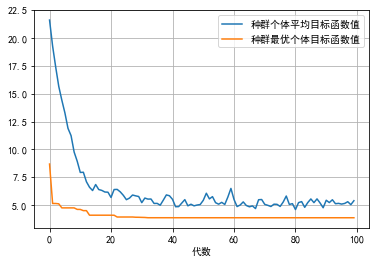

最优的目标函数值为：3.849711533384501
最优的控制变量值为：
11.875524427507123
5.775045014801477
有效进化代数：100
最优的一代是第 66 代
时间已过 0.689401388168335 秒


In [92]:
# 变量设置
x1 = [-3, 12.1] # 自变量1的范围
x2 = [4.1, 5.8] # 自变量2的范围
b1 = [1, 1] # 自变量1是否包含下界
b2 = [1, 1] # 自变量2是否包含上界
codes = [0, 0] # 自变量的编码方式，0表示采用标准二进制编码
precisions = [4, 4] # 在二进制/格雷码编码中代表自变量的编码精度，当控制变量是二进制/格雷编码时，该参数可控制编码的精度
scales = [0, 0] # 是否采用对数刻度
ranges=np.vstack([x1, x2]).T # 生成自变量的范围矩阵
borders = np.vstack([b1, b2]).T # 生成自变量的边界矩阵
# 生成区域描述器
FieldD = ga.crtfld(ranges, borders, precisions, codes, scales)

# 调用编程模板(设置problem = 'R'处理实数型变量问题，详见该算法模板的源代码)
[pop_trace, var_trace, times] = sga_new_code_templet(aimfuc, None, FieldD, problem = 'R', maxormin = 1, MAXGEN = 100, NIND = 100, SUBPOP = 1, GGAP = 0.8, selectStyle = 'sus', recombinStyle = 'xovdp', recopt = None, pm = None, distribute = True, drawing = 1)

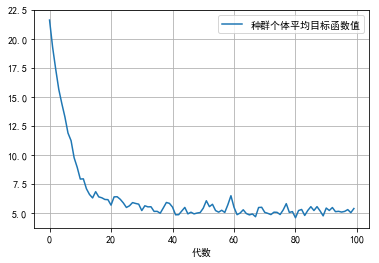

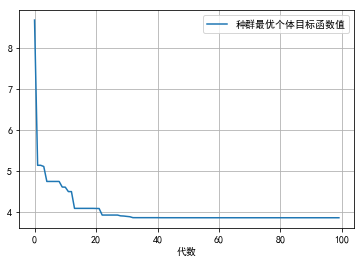

In [149]:
ga.trcplot(pop_trace, [['种群个体平均目标函数值'],[ '种群最优个体目标函数值']])

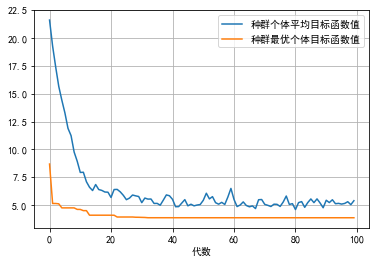

In [150]:
trcplot(pop_trace, [['种群个体平均目标函数值', '种群最优个体目标函数值']])

## test